Step 2: Loaded Data


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


Step 2: Preparing Observational Data
Step 3: Performing K-Means Clustering
Step 4: Visualizing Clustering Results


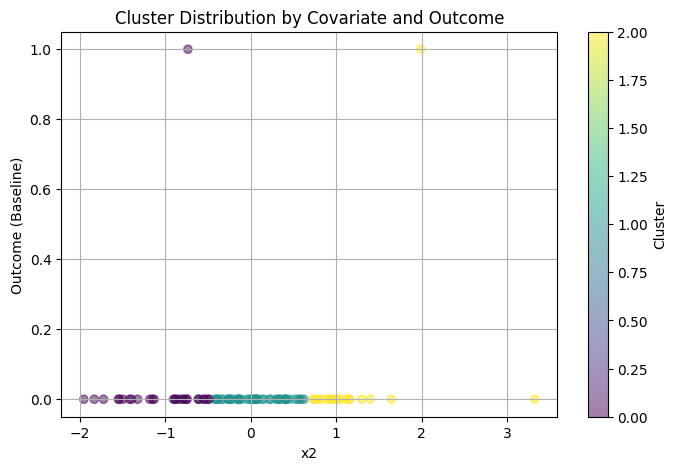

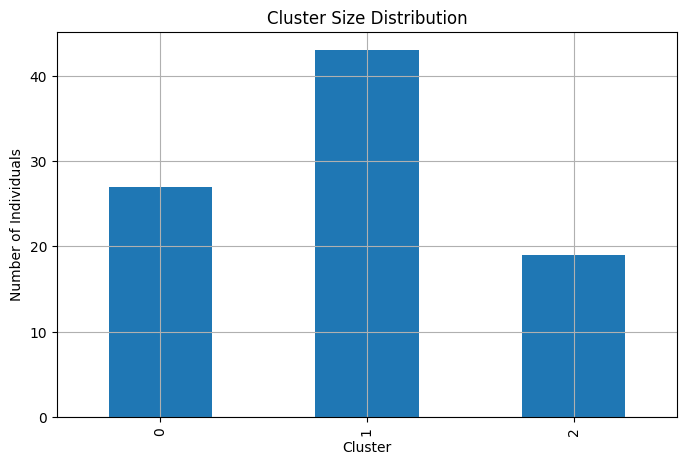

Step 2: Preparing Observational Data
Step 3: Performing K-Means Clustering
Step 4: Visualizing Clustering Results


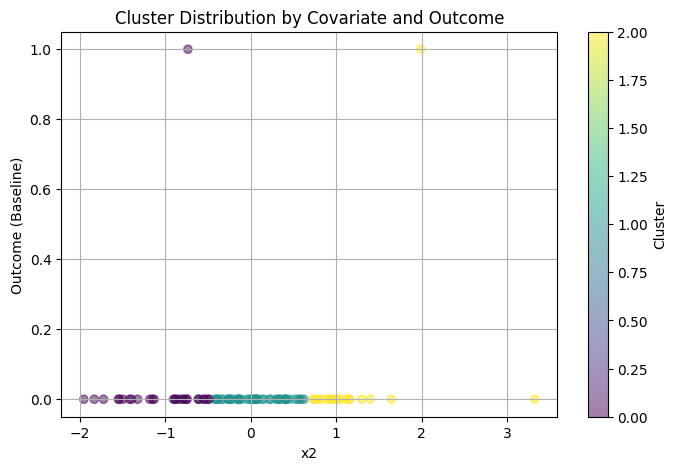

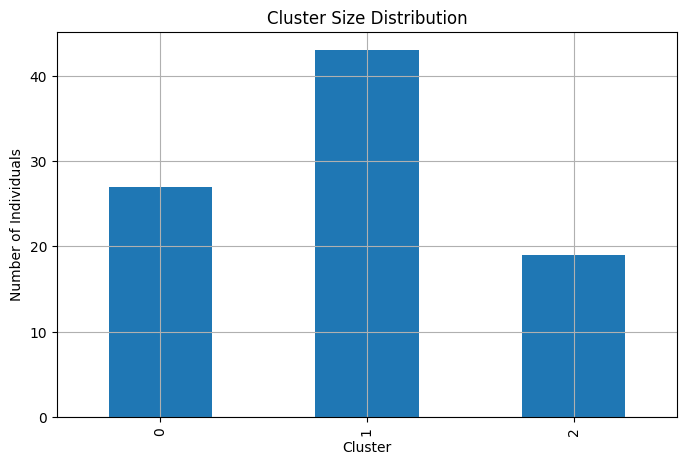

Step 5: Setting Up Censoring Weight Models
Step 5: Setting Up Censoring Weight Models
Step 7: Setting Up Switch Weight Models
Step 6 & 8: Calculating Weights
Step 6 & 8: Calculating Weights
Step 10: Setting Up Outcome Model
Step 9: Expanding Data into Trial Sequences
Step 10: Fitting Marginal Structural Model
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  781
Model:                          Logit   Df Residuals:                      772
Method:                           MLE   Df Model:                            8
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                  0.1949
Time:                        23:51:06   Log-Likelihood:                -56.501
converged:                       True   LL-Null:                       -70.175
Covariance Type:            nonrobust   LLR p-value:                 0.0006153
                            coef    std err          z   

C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


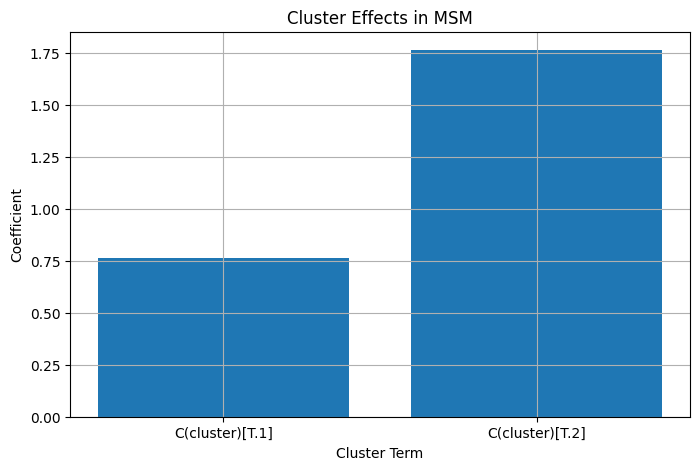

Step 12: Predicting Survival Differences
Step 13: Visualizing Survival Differences


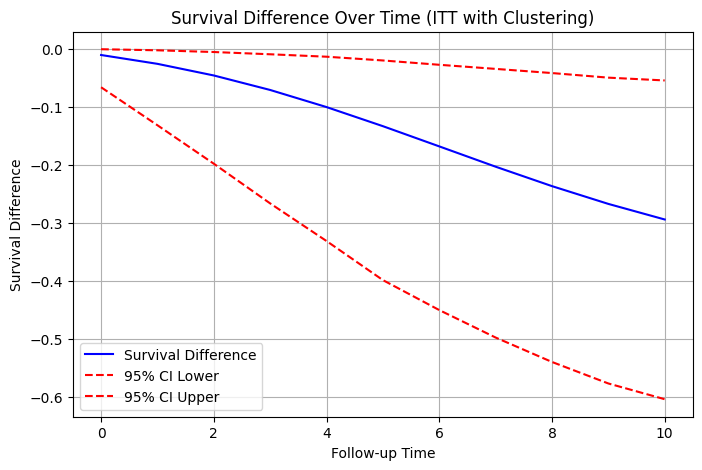

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
from patsy import dmatrix
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = None
        self.switch_weights = None if estimand != "PP" else {}
        self.expanded_data = None
        self.outcome_model = None
        self.outcome_data = None
        self.save_dir = None
        self.clusters = None
        self.scaler = None

    # Step 2 & 3: Prepare Data and Perform Clustering
    def set_data(self, data, id="id", period="period", treatment="treatment", outcome="outcome", eligible="eligible", censor_event="censored"):
        print("Step 2: Preparing Observational Data")
        data = data.rename(columns={id: "id", period: "period", treatment: "treatment", outcome: "outcome", eligible: "eligible", censor_event: "censored"})
        data = data.sort_values(by=["id", "period"])
        data["treatment_lag"] = data.groupby("id")["treatment"].shift(1).fillna(0)
        if self.estimand == "PP":
            data["switch"] = (data["treatment"] != data["treatment_lag"]) & (~data["treatment_lag"].isna())
        self.data = data
        self._perform_clustering()
        return self

    def _perform_clustering(self, n_clusters=3):
        print("Step 3: Performing K-Means Clustering")
        baseline_data = self.data.drop_duplicates(subset=["id"], keep="first").copy()
        covariates = ['x2']  # Adjust based on your TTE-v2 file
        X = baseline_data[covariates].values
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        baseline_data['cluster'] = clusters
        self.data = self.data.merge(baseline_data[['id', 'cluster']], on='id', how='left')
        self.clusters = clusters
        self._visualize_clusters(baseline_data, covariates)

    # Step 4: Visualize Clustering Results
    def _visualize_clusters(self, baseline_data, covariates):
        print("Step 4: Visualizing Clustering Results")
        plt.figure(figsize=(8, 5))
        plt.scatter(baseline_data[covariates[0]], baseline_data['outcome'].fillna(0), c=baseline_data['cluster'], cmap='viridis', alpha=0.5)
        plt.xlabel(covariates[0])
        plt.ylabel("Outcome (Baseline)")
        plt.title("Cluster Distribution by Covariate and Outcome")
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()

        # Cluster size histogram
        plt.figure(figsize=(8, 5))
        baseline_data['cluster'].value_counts().sort_index().plot(kind='bar')
        plt.xlabel("Cluster")
        plt.ylabel("Number of Individuals")
        plt.title("Cluster Size Distribution")
        plt.grid(True)
        plt.show()

    # Step 5: Set Up Censoring Weight Models
    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models, model_fitter, save_path=None):
        print("Step 5: Setting Up Censoring Weight Models")
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter,
            "save_path": save_path,
            "fitted_models": {}
        }
        return self

    # Step 7: Set Up Switch Weight Models (PP Only)
    def set_switch_weight_model(self, numerator, denominator, model_fitter, save_path=None):
        if self.estimand != "PP":
            raise ValueError("Switch weights are only applicable for PP estimand.")
        print("Step 7: Setting Up Switch Weight Models")
        self.switch_weights = {
            "numerator": numerator,
            "denominator": denominator,
            "model_fitter": model_fitter,
            "save_path": save_path,
            "fitted_models": {}
        }
        return self

    # Step 6 & 8: Calculate Weights
    def calculate_weights(self):
        print("Step 6 & 8: Calculating Weights")
        if self.censor_weights is None:
            raise ValueError("Censor weight model not specified.")
        data = self.data.copy()
        censor_event = self.censor_weights["censor_event"]
        data["not_censored"] = 1 - data[censor_event]

        if self.censor_weights["pool_models"] == "numerator":
            num_formula = f"not_censored ~ {self.censor_weights['numerator']}"
            model_n = smf.logit(num_formula, data=data).fit(disp=0, maxiter=1000, method='bfgs')
            den_formula = f"not_censored ~ {self.censor_weights['denominator']}"
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0, maxiter=1000, method='bfgs')
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0, maxiter=1000, method='bfgs')
            data["censor_prob_num"] = model_n.predict(data)
            data["censor_prob_den"] = np.where(data["treatment_lag"] == 0, model_d0.predict(data), model_d1.predict(data))
        else:
            num_formula = f"not_censored ~ {self.censor_weights['numerator']}"
            model_n0 = smf.logit(num_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0, maxiter=1000, method='bfgs')
            model_n1 = smf.logit(num_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0, maxiter=1000, method='bfgs')
            den_formula = f"not_censored ~ {self.censor_weights['denominator']}"
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0, maxiter=1000, method='bfgs')
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0, maxiter=1000, method='bfgs')
            data["censor_prob_num"] = np.where(data["treatment_lag"] == 0, model_n0.predict(data), model_n1.predict(data))
            data["censor_prob_den"] = np.where(data["treatment_lag"] == 0, model_d0.predict(data), model_d1.predict(data))

        data["censor_prob_num"] = np.clip(data["censor_prob_num"], 1e-10, 1-1e-10)
        data["censor_prob_den"] = np.clip(data["censor_prob_den"], 1e-10, 1-1e-10)
        data["wtC"] = data["censor_prob_num"] / data["censor_prob_den"]
        data["wtC"] = data.groupby("id")["wtC"].cumprod()

        if self.estimand == "PP" and self.switch_weights:
            data["stayed_on_treatment"] = (~data["switch"]).astype(int)
            num_formula = f"stayed_on_treatment ~ {self.switch_weights['numerator']}"
            den_formula = f"stayed_on_treatment ~ {self.switch_weights['denominator']}"
            model_n0 = smf.logit(num_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0, maxiter=1000, method='bfgs')
            model_n1 = smf.logit(num_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0, maxiter=1000, method='bfgs')
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0, maxiter=1000, method='bfgs')
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0, maxiter=1000, method='bfgs')
            data["switch_prob_num"] = np.where(data["treatment_lag"] == 0, model_n0.predict(data), model_n1.predict(data))
            data["switch_prob_den"] = np.where(data["treatment_lag"] == 0, model_d0.predict(data), model_d1.predict(data))
            data["switch_prob_num"] = np.clip(data["switch_prob_num"], 1e-10, 1-1e-10)
            data["switch_prob_den"] = np.clip(data["switch_prob_den"], 1e-10, 1-1e-10)
            data["wtS"] = data["switch_prob_num"] / data["switch_prob_den"]
            data["wtS"] = data.groupby("id")["wtS"].cumprod()
            data["weight"] = data["wtC"] * data["wtS"]
        else:
            data["weight"] = data["wtC"]

        self.data = data
        return self

    # Step 9: Expand Trials
    def expand_trials(self):
        print("Step 9: Expanding Data into Trial Sequences")
        data = self.data.copy()
        periods = data["period"].unique()
        expanded_rows = []
        for trial_period in periods:
            eligible = data[(data["period"] == trial_period) & (data["eligible"] == 1)]
            for _, row in eligible.iterrows():
                patient_data = data[data["id"] == row["id"]]
                start_idx = patient_data.index[patient_data["period"] == trial_period][0]
                follow_up = patient_data.loc[start_idx:]
                assigned_treatment = row["treatment"]
                for t, f_row in enumerate(follow_up.itertuples()):
                    expanded_row = {
                        "id": row["id"],
                        "trial_period": trial_period,
                        "followup_time": t,
                        "outcome": f_row.outcome,
                        "weight": f_row.weight,
                        "treatment": f_row.treatment,
                        "assigned_treatment": assigned_treatment,
                        "x2": f_row.x2,
                        "cluster": f_row.cluster
                    }
                    if self.estimand == "PP" and f_row.switch:
                        break
                    expanded_rows.append(expanded_row)
        self.expanded_data = pd.DataFrame(expanded_rows)
        return self

    # Step 10: Set Outcome Model
    def set_outcome_model(self, adjustment_terms="x2"):
        print("Step 10: Setting Up Outcome Model")
        terms = "assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        if adjustment_terms:
            terms += f" + {adjustment_terms}"
        self.outcome_model = {"formula": f"outcome ~ {terms} + C(cluster)", "fitted": None}
        return self

    def load_expanded_data(self, seed=1234, p_control=0.5):
        np.random.seed(seed)
        expanded = self.expanded_data.copy()
        control_mask = (expanded["outcome"] == 0)
        sample_mask = control_mask & (np.random.random(len(expanded)) < p_control)
        self.outcome_data = expanded[sample_mask | ~control_mask].copy()
        self.outcome_data["sample_weight"] = np.where(self.outcome_data["outcome"] == 0, 1 / p_control, 1)
        return self

    # Step 10 & 11: Fit MSM and Analyze Cluster Impact
    def fit_msm(self, weight_cols=["weight", "sample_weight"], modify_weights=None):
        print("Step 10: Fitting Marginal Structural Model")
        data = self.outcome_data.copy()
        data["w"] = data[weight_cols].prod(axis=1)
        if modify_weights:
            data["w"] = modify_weights(data["w"])
        model = smf.logit(self.outcome_model["formula"], data=data)
        result = model.fit(weights=data["w"], maxiter=1000, disp=0, method='bfgs')
        self.outcome_model["fitted"] = result
        print(result.summary())
        self._analyze_cluster_impact(result)
        return self

    def _analyze_cluster_impact(self, result):
        print("Step 11: Analyzing Cluster Impact on MSM")
        cluster_coeffs = {k: v for k, v in result.params.items() if "C(cluster)" in k}
        print("Cluster Coefficients:")
        for k, v in cluster_coeffs.items():
            print(f"{k}: {v:.4f}")
        # Optional: Plot cluster-specific effects (simplified here)
        plt.figure(figsize=(8, 5))
        plt.bar(cluster_coeffs.keys(), cluster_coeffs.values())
        plt.xlabel("Cluster Term")
        plt.ylabel("Coefficient")
        plt.title("Cluster Effects in MSM")
        plt.grid(True)
        plt.show()

    # Step 12 & 13: Predict and Visualize Survival Differences
    def predict(self, newdata, predict_times, type="difference"):
        print("Step 12: Predicting Survival Differences")
        model = self.outcome_model["fitted"]
        params = model.params
        cov = model.cov_params()
        if not np.all(np.linalg.eigvals(cov) > 0):
            print("Warning: Covariance matrix is not positive definite. Using diagonal approximation.")
            cov = np.diag(np.diag(cov))
        n_bootstrap = 1000
        bootstrap_params = np.random.multivariate_normal(params, cov, size=n_bootstrap)

        rhs = self.outcome_model["formula"].split("~")[1].strip()
        mean_row = newdata[newdata["trial_period"] == 1][['x2', 'trial_period']].mean().to_frame().T
        most_common_cluster = int(newdata["cluster"].mode()[0])
        ref_data = pd.DataFrame({
            'x2': mean_row['x2'].iloc[0],
            'trial_period': mean_row['trial_period'].iloc[0],
            'followup_time': predict_times * 2,
            'assigned_treatment': [0] * len(predict_times) + [1] * len(predict_times),
            'cluster': [most_common_cluster] * len(predict_times) * 2
        })
        ref_data['cluster'] = pd.Categorical(ref_data['cluster'], categories=[0, 1, 2])
        X_pred = dmatrix(f"{rhs}", ref_data, return_type="dataframe")
        trt0_mask = ref_data["assigned_treatment"] == 0
        X_pred_trt0 = X_pred[trt0_mask]
        X_pred_trt1 = X_pred[~trt0_mask]

        linear_pred_trt0 = np.dot(X_pred_trt0, params)
        p_trt0 = 1 / (1 + np.exp(-np.clip(linear_pred_trt0, -500, 500)))
        survival_trt0 = np.cumprod(1 - p_trt0)

        linear_pred_trt1 = np.dot(X_pred_trt1, params)
        p_trt1 = 1 / (1 + np.exp(-np.clip(linear_pred_trt1, -500, 500)))
        survival_trt1 = np.cumprod(1 - p_trt1)

        diff = survival_trt1 - survival_trt0

        diff_bootstrap = np.zeros((n_bootstrap, len(predict_times)))
        for i in range(n_bootstrap):
            beta_i = bootstrap_params[i]
            linear_pred_trt0_i = np.dot(X_pred_trt0, beta_i)
            p_trt0_i = 1 / (1 + np.exp(-np.clip(linear_pred_trt0_i, -500, 500)))
            survival_trt0_i = np.cumprod(1 - p_trt0_i)
            linear_pred_trt1_i = np.dot(X_pred_trt1, beta_i)
            p_trt1_i = 1 / (1 + np.exp(-np.clip(linear_pred_trt1_i, -500, 500)))
            survival_trt1_i = np.cumprod(1 - p_trt1_i)
            diff_bootstrap[i, :] = survival_trt1_i - survival_trt0_i

        ci_lower = np.percentile(diff_bootstrap, 2.5, axis=0)
        ci_upper = np.percentile(diff_bootstrap, 97.5, axis=0)

        if type == "difference":
            print("Step 13: Visualizing Survival Differences")
            plt.figure(figsize=(8, 5))
            plt.plot(predict_times, diff, 'b-', label="Survival Difference")
            plt.plot(predict_times, ci_lower, 'r--', label="95% CI Lower")
            plt.plot(predict_times, ci_upper, 'r--', label="95% CI Upper")
            plt.xlabel("Follow-up Time")
            plt.ylabel("Survival Difference")
            plt.title(f"Survival Difference Over Time ({self.estimand} with Clustering)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return {
            "difference": {
                "followup_time": predict_times,
                "survival_diff": diff,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper
            }
        }

class TrialSequenceITT(TrialSequence):
    def __init__(self):
        super().__init__("ITT")

    def set_censor_weight_model(self, censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="numerator", model_fitter="stats_glm_logit", save_path=None):
        return super().set_censor_weight_model(censor_event, numerator, denominator, pool_models, model_fitter, save_path)

class TrialSequencePP(TrialSequence):
    def __init__(self):
        super().__init__("PP")

    def set_censor_weight_model(self, censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="none", model_fitter="stats_glm_logit", save_path=None):
        return super().set_censor_weight_model(censor_event, numerator, denominator, pool_models, model_fitter, save_path)

# Main Execution
if __name__ == "__main__":
    trial_itt = TrialSequenceITT()
    trial_pp = TrialSequencePP()

    trial_itt_dir = os.path.join(os.path.abspath("."), "trial_itt")
    trial_pp_dir = os.path.join(os.path.abspath("."), "trial_pp")
    os.makedirs(trial_itt_dir, exist_ok=True)
    os.makedirs(trial_pp_dir, exist_ok=True)
    trial_itt.save_dir = trial_itt_dir
    trial_pp.save_dir = trial_pp_dir

    # Load Data
    file_path = "data/data_censored.csv" 
    data_censored = pd.read_csv(file_path)
    print("Step 2: Loaded Data")
    display(data_censored.head())

    # Execute Steps
    trial_itt.set_data(data_censored)
    trial_pp.set_data(data_censored)
    trial_itt.set_censor_weight_model(save_path=trial_itt_dir)
    trial_pp.set_censor_weight_model(save_path=trial_pp_dir)
    trial_pp.set_switch_weight_model(numerator="age", denominator="age + x1 + x3", model_fitter="stats_glm_logit", save_path=trial_pp_dir)
    trial_itt.calculate_weights()
    trial_pp.calculate_weights()
    trial_itt.set_outcome_model(adjustment_terms="x2")
    trial_itt.expand_trials()
    trial_itt.load_expanded_data()
    trial_itt.fit_msm(modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99)))
    predict_times = list(range(11))
    newdata = trial_itt.outcome_data[trial_itt.outcome_data["trial_period"] == 1]
    preds = trial_itt.predict(newdata, predict_times, type="difference")

# Insights

# Detailed Insights on the TTE-v2 Process
1. Target Trial Specification (Step 1)
Insight: The choice between ITT (Intention-to-Treat) and PP (Per-Protocol) estimands defines the analysis framework. ITT assesses the effect of assigned treatment regardless of adherence, while PP evaluates the effect of sustained treatment, emulating a perfectly adherent trial.
Implication: ITT simplifies the analysis by avoiding adherence modeling, but it may mask treatment effects if adherence varies. PP requires additional steps to account for switching, increasing complexity and reliance on adherence assumptions.
2. Data Preparation (Step 2)
Insight: Sorting by id and period ensures temporal consistency, while computing treatment_lag supports modeling of treatment history and switching. Missing values in treatment_lag are filled with 0, assuming no prior treatment at the first period.
Implication: Data quality is critical—misaligned periods or duplicate IDs could bias estimates. For PP, accurate switch detection via treatment_lag is essential, requiring robust preprocessing.
3. Clustering on Baseline Covariates (Step 3)
Insight: K-Means clustering on x2 segments the population into subgroups, with standardization ensuring scale invariance and a fixed random seed ensuring reproducibility.
Implication: Clustering aims to capture unobserved heterogeneity, potentially enhancing the MSM by adjusting for subgroup differences. Its effectiveness depends on the chosen covariate’s relevance to the outcome and treatment, and a single-covariate approach may limit multidimensional insight.
4. Visualization of Clustering Results (Step 4)
Insight: Visualizing x2 vs. baseline outcome by cluster assesses separation, while a cluster size histogram evaluates distribution balance.
Implication: Clear separation validates clustering’s utility for stratification, while imbalanced sizes may signal overfitting or underrepresentation risks in downstream models. Visual checks guide whether clusters add meaningful structure or merely noise.
5. Censoring Weight Models (Step 5 & 6)
Insight: Stabilized IPCW corrects for informative censoring by modeling the probability of remaining uncensored. Pooling numerator models assumes less treatment-dependent censoring, while stratifying by treatment history accounts for differential risks.
Implication: Proper model specification ensures weights adjust for censoring bias without destabilizing estimates. Treatment-stratified models increase precision but demand sufficient data per stratum.
6. Switch Weight Models (Step 7 & 8, PP Only)
Insight: For PP, switch weights adjust for adherence by modeling the probability of staying on initial treatment, with numerator and denominator terms balancing baseline and time-varying factors.
Implication: These weights refine the PP estimand by isolating adherent effects, but their accuracy hinges on capturing relevant predictors of switching. Complex denominators may reduce bias but increase variance if over-specified.
7. Trial Sequence Expansion (Step 9)
Insight: Expanding data into trial sequences aligns observational data with a trial structure, assigning follow-up times from eligible periods. PP stops at switches, while ITT includes all follow-ups.
Implication: This step ensures causal questions match trial logic, but longer sequences risk bias if censoring or switching is unmodeled. The assigned_treatment variable preserves the initial assignment critical to both estimands.
8. Marginal Structural Model with Clustering (Step 10)
Insight: The MSM uses weighted logistic regression to estimate treatment effects, incorporating time terms, covariates, and clusters as categorical variables. Polynomial terms model non-linear time effects.
Implication: This approach adjusts for confounding and censoring while allowing cluster-specific effects. Complexity from polynomials and clusters risks overfitting, requiring careful validation.
9. Cluster Impact Analysis (Step 11)
Insight: Examining cluster coefficients in the MSM quantifies their role in outcome variation, with visualization aiding interpretation of heterogeneity.
Implication: Significant cluster effects justify their inclusion, potentially guiding subgroup analyses. Minimal impact suggests clustering may be redundant, simplifying the model.
10. Survival Difference Prediction (Step 12)
Insight: Survival probabilities are predicted from the MSM, with differences computed between treatment and control arms. Bootstrap resampling estimates uncertainty via confidence intervals.
Implication: This step translates MSM coefficients into interpretable causal effects, with CIs reflecting estimate precision. Robustness depends on weight stability and model fit.
11. Visualization of Survival Results (Step 13)
Insight: Plotting survival differences with CIs communicates the treatment effect’s trajectory and uncertainty, mirroring RCT-style reporting.
Implication: Visual clarity enhances interpretability, with CI width indicating power and reliability. Cluster-specific visualization could further reveal heterogeneity if implemented.